In [66]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)

In [2]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")

In [3]:
df_test["trip_duration"] = -1

In [4]:
full_df = pd.concat([df_train, df_test], axis=0)

In [71]:
import haversine
def haversine_distance(x):
    a_lat, a_lon, b_lat, b_lon = x
    return haversine.haversine((a_lat, a_lon), (b_lat, b_lon), unit="km")

In [37]:
import multiprocess
# Multithreaded apply function for a dataframe. This uses multiprocessing to map a function to a series, vastly speeding up feature generation

N_THREADS = 8
def apply_multithreaded(data, func):
    pool = multiprocess.Pool(N_THREADS)  # Spawn a pool of processes
    data = data.values  # Retrieve a numpy array which can be iterated over

    result = pool.map(func, data)  # Map the function over the data multi-threaded
    pool.close()  # Close the threads
    return result

In [7]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [12]:
full_df["store_and_fwd_flag"] = full_df["store_and_fwd_flag"].apply(lambda x: 1 if x == "Y" else 0)

In [14]:
full_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag      int64
trip_duration           int64
dtype: object

In [15]:
full_df["pickup_datetime"] = pd.to_datetime(full_df["pickup_datetime"])
full_df["dropoff_datetime"] = pd.to_datetime(full_df["dropoff_datetime"])

In [20]:
full_df["pickup_unixtime"] = [np.int64(t.value) / 1000000000 for t in full_df["pickup_datetime"]]

In [26]:
full_df["daily_minute"] = [t.hour * 60 + t.minute for t in full_df["pickup_datetime"]]

In [27]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_unixtime,daily_minute
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,1457976295.000,1044
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,1465692215.000,43
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1453203324.000,695
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,1459971151.000,1172
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,1458999055.000,810


In [28]:
full_df["duration"] = full_df["dropoff_datetime"] - full_df["pickup_datetime"]

In [30]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_unixtime,daily_minute,duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,1457976295.000,1044,00:07:35
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,1465692215.000,43,00:11:03
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1453203324.000,695,00:35:24
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,1459971151.000,1172,00:07:09
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,1458999055.000,810,00:07:15


In [33]:
full_df["day_of_week"] = [t.dayofweek for t in full_df["pickup_datetime"]]

In [35]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_unixtime,daily_minute,duration,day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,1457976295.000,1044,00:07:35,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,1465692215.000,43,00:11:03,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1453203324.000,695,00:35:24,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,1459971151.000,1172,00:07:09,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,1458999055.000,810,00:07:15,5


### Create Distance Features

In [72]:
# Map the three distance functions over all samples in the training set
full_df["dist_l1"] = np.abs(full_df["pickup_latitude"] - full_df["dropoff_latitude"]) + np.abs(full_df["pickup_longitude"] - full_df["dropoff_longitude"])
full_df["dist_l2"] = np.sqrt((full_df["pickup_latitude"] - full_df["dropoff_latitude"]) ** 2 + (full_df["pickup_longitude"] - full_df['dropoff_longitude']) ** 2)
# As haversine is not vectorised, we use the multithreading approach for speed
full_df["dist_haversine"] = apply_multithreaded(full_df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']], haversine_distance)

In [73]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_unixtime,daily_minute,duration,day_of_week,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle,day,hour,daily_count,hourly_count,haversine_speed,haversine_speed_estim
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,1457976295.000,1044,00:07:35,0,0.020,0.018,1.499,-0.002,0.018,172.412,2016-03-14,17,11564,109399,0.003,-1.509
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,1465692215.000,43,00:11:03,6,0.026,0.020,1.806,-0.007,-0.019,21.244,2016-06-12,0,10086,75962,0.003,-1.514
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1453203324.000,695,00:35:24,1,0.080,0.060,6.385,-0.054,-0.026,63.965,2016-01-19,11,11315,97621,0.003,-7.044
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,1459971151.000,1172,00:07:09,2,0.015,0.013,1.486,-0.013,-0.002,80.457,2016-04-06,19,12045,128745,0.003,-1.586
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,1458999055.000,810,00:07:15,5,0.011,0.011,1.189,-0.011,0.000,90.695,2016-03-26,13,12132,101997,0.003,-1.206


### Create Direction of Travel Features

In [40]:
full_df["delta_lat"] = full_df["dropoff_latitude"] - full_df["pickup_latitude"]
full_df["delta_long"] = full_df["dropoff_longitude"] - full_df["pickup_longitude"]
full_df["angle"] = (180 / np.pi) * np.arctan2(full_df["delta_lat"], full_df["delta_long"]) + 180

In [69]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_unixtime,daily_minute,duration,day_of_week,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle,day,hour,daily_count,hourly_count,haversine_speed,haversine_speed_estim
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,1457976295.000,1044,00:07:35,0,0.020,0.018,1.499,-0.002,0.018,172.412,2016-03-14,17,11564,109399,0.003,-1.509
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,1465692215.000,43,00:11:03,6,0.026,0.020,1.806,-0.007,-0.019,21.244,2016-06-12,0,10086,75962,0.003,-1.514
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1453203324.000,695,00:35:24,1,0.080,0.060,6.385,-0.054,-0.026,63.965,2016-01-19,11,11315,97621,0.003,-7.044
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,1459971151.000,1172,00:07:09,2,0.015,0.013,1.486,-0.013,-0.002,80.457,2016-04-06,19,12045,128745,0.003,-1.586
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,1458999055.000,810,00:07:15,5,0.011,0.011,1.189,-0.011,0.000,90.695,2016-03-26,13,12132,101997,0.003,-1.206


### Creating Traffic Features

In [46]:
full_df['day'] = full_df['pickup_datetime'].dt.date
full_df['hour'] = full_df['pickup_datetime'].dt.hour

In [47]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,duration,day_of_week,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle,day,hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,...,00:07:35,0,0.020,0.018,1.499,-0.002,0.018,172.412,2016-03-14,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,...,00:11:03,6,0.026,0.020,1.806,-0.007,-0.019,21.244,2016-06-12,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,...,00:35:24,1,0.080,0.060,6.385,-0.054,-0.026,63.965,2016-01-19,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,...,00:07:09,2,0.015,0.013,1.486,-0.013,-0.002,80.457,2016-04-06,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,...,00:07:15,5,0.011,0.011,1.189,-0.011,0.000,90.695,2016-03-26,13


In [49]:
daily_traffic = full_df.groupby('day')['day'].count()  # Count the number of trips on each day
hourly_traffic = full_df.groupby('hour')['hour'].count()  # Count the number of trips in each hour

In [50]:
# Loop over the data and lookup the count information on the corresponding day to fill the feature
full_df['daily_count'] = full_df['day'].apply(lambda day: daily_traffic[day])
full_df['hourly_count'] = full_df['hour'].apply(lambda hour: hourly_traffic[hour])

In [51]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle,day,hour,daily_count,hourly_count
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,...,0.020,0.018,1.499,-0.002,0.018,172.412,2016-03-14,17,11564,109399
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,...,0.026,0.020,1.806,-0.007,-0.019,21.244,2016-06-12,0,10086,75962
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,...,0.080,0.060,6.385,-0.054,-0.026,63.965,2016-01-19,11,11315,97621
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,...,0.015,0.013,1.486,-0.013,-0.002,80.457,2016-04-06,19,12045,128745
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,...,0.011,0.011,1.189,-0.011,0.000,90.695,2016-03-26,13,12132,101997


### Creating Time Estimate Features

In [55]:
full_df['haversine_speed'] = full_df['dist_haversine'] / full_df['trip_duration']  # Calculate haversine speed for training set
hourly_speed = full_df.groupby('hour')['haversine_speed'].mean()  # Find average haversine_speed for each hour in the training set
hourly_speed_fill = full_df['haversine_speed'].mean()  # Get mean across whole dataset for filling unknowns

# Create feature
full_df_hourly_speed = full_df['hour'].apply(lambda hour: hourly_speed[hour] if hour in hourly_speed else hourly_speed_fill)
full_df['haversine_speed_estim'] = full_df['dist_haversine'] / full_df_hourly_speed

In [67]:
full_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_unixtime,daily_minute,duration,day_of_week,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle,day,hour,daily_count,hourly_count,haversine_speed,haversine_speed_estim
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,0,455,1457976295.000,1044,00:07:35,0,0.020,0.018,1.499,-0.002,0.018,172.412,2016-03-14,17,11564,109399,0.003,-1.509
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,0,663,1465692215.000,43,00:11:03,6,0.026,0.020,1.806,-0.007,-0.019,21.244,2016-06-12,0,10086,75962,0.003,-1.514
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,0,2124,1453203324.000,695,00:35:24,1,0.080,0.060,6.385,-0.054,-0.026,63.965,2016-01-19,11,11315,97621,0.003,-7.044
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,0,429,1459971151.000,1172,00:07:09,2,0.015,0.013,1.486,-0.013,-0.002,80.457,2016-04-06,19,12045,128745,0.003,-1.586
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,0,435,1458999055.000,810,00:07:15,5,0.011,0.011,1.189,-0.011,0.000,90.695,2016-03-26,13,12132,101997,0.003,-1.206


### Feature Inspection

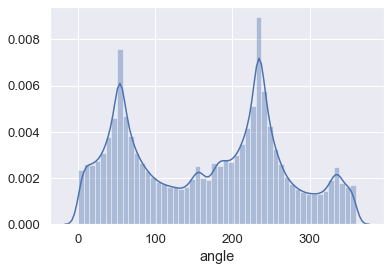

In [70]:
import seaborn as sns

sns.distplot(full_df["angle"])

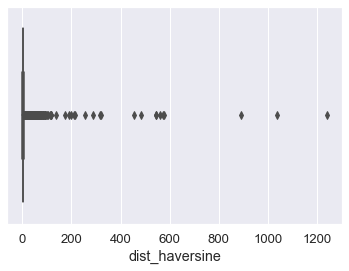

In [63]:
sns.boxplot(full_df["dist_haversine"])

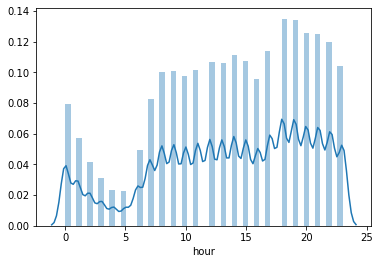

In [59]:
sns.distplot(full_df["hour"])

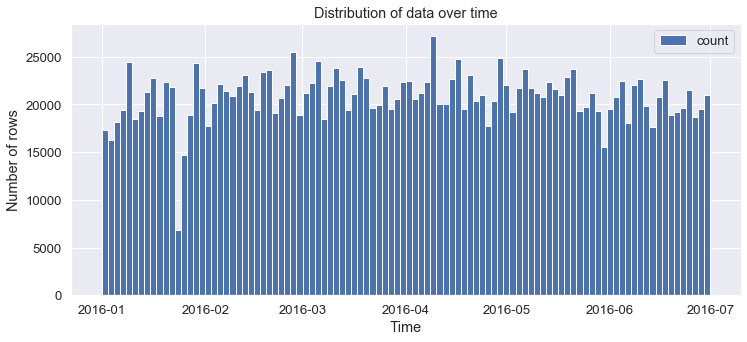

In [61]:
import matplotlib.pyplot as plt

# Plot distribution of the dataset
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 5))
plt.hist([x.to_pydatetime() for x in full_df['pickup_datetime']], bins=100, label='count')
plt.title('Distribution of data over time')
plt.xlabel('Time')
plt.ylabel('Number of rows')
plt.legend()
plt.show()

In [68]:
full_df[full_df["dist_haversine"] > 100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_unixtime,daily_minute,duration,day_of_week,dist_l1,dist_l2,dist_haversine,delta_lat,delta_long,angle,day,hour,daily_count,hourly_count,haversine_speed,haversine_speed_estim
14502,id1092161,1,2016-04-15 22:35:08,2016-04-16 00:34:21,1,-73.782,40.645,-72.711,41.312,0,7153,1460759708.000,1355,01:59:13,4,1.737,1.261,116.497,0.667,1.070,211.921,2016-04-15,22,13237,115059,0.016,-103.849
114376,id1311087,1,2016-02-29 12:16:29,2016-02-29 18:47:09,3,-75.456,39.804,-73.796,40.708,0,23440,1456748189.000,736,06:30:40,0,2.564,1.890,173.030,0.904,1.660,208.568,2016-02-29,12,10415,102321,0.007,-190.028
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.810,51.881,-73.987,40.751,0,792,1462647533.000,1138,00:13:12,5,12.308,11.193,1240.910,-11.130,-1.178,83.961,2016-05-07,18,13287,129441,1.567,-1359.269
275644,id0978162,1,2016-02-24 16:20:59,2016-02-24 16:35:34,4,-75.354,34.712,-73.835,32.181,0,875,1456330859.000,980,00:14:35,2,4.051,2.952,314.765,-2.531,1.519,120.976,2016-02-24,16,12031,92027,0.360,-301.882
283102,id2778014,2,2016-01-17 16:43:09,2016-01-17 16:50:16,1,-73.997,40.729,-72.671,40.614,0,427,1453048989.000,1003,00:07:07,6,1.441,1.331,112.549,-0.115,1.326,175.056,2016-01-17,16,11307,92027,0.264,-107.943
377068,id0116374,1,2016-04-02 20:33:19,2016-04-02 20:38:01,1,-74.007,40.717,-76.963,38.946,0,282,1459629199.000,1233,00:04:42,5,4.727,3.446,320.126,-1.771,-2.956,30.927,2016-04-02,20,13313,120367,1.135,-311.173
397526,id0982904,1,2016-04-28 13:32:14,2016-04-28 14:14:09,2,-73.871,40.774,-79.818,38.964,0,2515,1461850334.000,812,00:41:55,3,7.757,6.217,545.854,-1.810,-5.947,16.925,2016-04-28,13,12131,101997,0.217,-553.870
512980,id2066082,1,2016-01-25 23:53:17,2016-01-26 01:25:46,1,-73.878,40.772,-72.906,41.320,0,5549,1453765997.000,1433,01:32:29,0,1.519,1.116,101.736,0.548,0.972,209.403,2016-01-25,23,8542,99656,0.018,-86.045
595540,id1723416,1,2016-03-20 21:07:56,2016-03-20 21:12:35,1,-78.547,40.817,-79.786,40.918,0,279,1458508076.000,1267,00:04:39,6,1.339,1.243,104.760,0.101,-1.239,355.361,2016-03-20,21,11719,119931,0.375,-98.141
644165,id0401529,2,2016-06-02 15:19:35,2016-06-02 15:32:59,1,-73.981,40.757,-74.240,38.478,0,804,1464880775.000,919,00:13:24,3,2.538,2.294,254.364,-2.279,-0.259,83.508,2016-06-02,15,11834,102811,0.316,-247.999
